# Исследование продуктовых гипотез

В нашем распоряжении данные о 9 гипотезах для увеличения выручки, подготовленных отделом маркетинга. 

Нам предстоит приоритизировать гипотезы, запустить A/B тест одной из гипотез и проанализировать результаты.

## Изучение данных из файлов

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import seaborn as sns
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.simplefilter('ignore')

<ipython-input-1-61b3ef1c0bd0>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
# чтение файла с данными и сохранение в датафреймы

hyp = pd.read_csv('../../yandex-praktikum-sources/ab-hypothesis.csv')
orders = pd.read_csv('../../yandex-praktikum-sources/ab-orders.csv')
visitors = pd.read_csv('../../yandex-praktikum-sources/ab-visitors.csv')

In [3]:
# просмотр информации о таблицах и проверка наличия дубликатов
d = {'hypothesis' : hyp, 'orders' : orders, 'visitors' : visitors}
for a, i in d.items():
    print(f'Название датафрейма {a}, количество дубликатов {i.duplicated().sum()}')
    display(i.head())
    display(i.info())
    print('- ' * 50)

Название датафрейма hypothesis, количество дубликатов 0


Hypothesis  \
0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей             
1  Запустить собственную службу доставки, что сократит срок доставки заказов                                      
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар            
4  Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                               

   Reach  Impact  Confidence  Efforts  
0  3      10      8           6        
1  2      5       4           10       
2  8      3       7           3        
3  8      3       3           8        
4  3      1       1           1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма orders, количество дубликатов 0


transactionId   visitorId        date  revenue group
0  3667963787     3312258926  2019-08-15  1650     B   
1  2804400009     3642806036  2019-08-15  730      B   
2  2961555356     4069496402  2019-08-15  400      A   
3  3797467345     1196621759  2019-08-15  9759     B   
4  2282983706     2322279887  2019-08-15  2308     B

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Название датафрейма visitors, количество дубликатов 0


date group  visitors
0  2019-08-01  A     719     
1  2019-08-02  A     619     
2  2019-08-03  A     507     
3  2019-08-04  A     717     
4  2019-08-05  A     756

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Согласно документации к данным:

1. Таблица `hypothesis.csv` содержит данные о гипотезах:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2. Таблица  `orders.csv` содержит данные о заказах в период проведения A/B теста:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.
3. Таблица `visitors.csv` содержит данные о посетителях сайта в период A/B теста:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Пропусков в данных нет, но названия столбцов не соответствуют snake case. Исправим это.

In [4]:
hyp.columns = [x.lower() for x in hyp.columns.values]
orders.columns = [x.replace('Id', '_id') for x in orders.columns.values]

In [5]:
# преобразование данных о времени
orders['date'] = pd.to_datetime(orders['date']).dt.date
visitors['date'] = pd.to_datetime(visitors['date']).dt.date

Данные к анализу подготовлены.

## Приоритизация гипотез

В нашем распоряжении файл с 9 гипотезами, для которых оценены значения `Reach`, `Impact`, `Confidence` и `Efforts`. Применим к этим оценкам фреймворки `ICE` и `RICE`.

In [6]:
hyp['ICE'] = hyp.impact * hyp.confidence / hyp.efforts

display(hyp[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

hypothesis  \
8  Запустить акцию, дающую скидку на товар в день рождения                                                        
0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей             
7  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок               
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию           
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1  Запустить собственную службу доставки, что сократит срок доставки заказов                                      
5  Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                       
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар            
4  Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                               

    ICE  
8 16.20  
0 13.33  
7 11.20  
6 8.00   
2 7.00   
1 2.00   
5 1.33   
3 1.12   
4 1.00

In [7]:
hyp['RICE'] = hyp.reach * hyp.impact * hyp.confidence / hyp.efforts

display(hyp[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

hypothesis  \
7  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок               
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей             
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию           
8  Запустить акцию, дающую скидку на товар в день рождения                                                        
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар            
1  Запустить собственную службу доставки, что сократит срок доставки заказов                                      
5  Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                       
4  Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                               

    RICE  
7 112.00  
2 56.00   
0 40.00   
6 40.00   
8 16.20   
3 9.00    
1 4.00    
5 4.00    
4 3.00

In [8]:
# визуализируем изменение порядка гипотез
t_ICE = hyp[['hypothesis', 'ICE']].sort_values(by='ICE').reset_index(drop=True).reset_index().drop('ICE', axis=1)
t_RICE = hyp[['hypothesis', 'RICE']].sort_values(by='RICE').reset_index(drop=True).reset_index().drop('RICE', axis=1)
t_all = t_ICE.merge(t_RICE, on='hypothesis')
t_all = t_all.set_axis(['ICE', 'hypothesis', 'RICE'], axis=1)

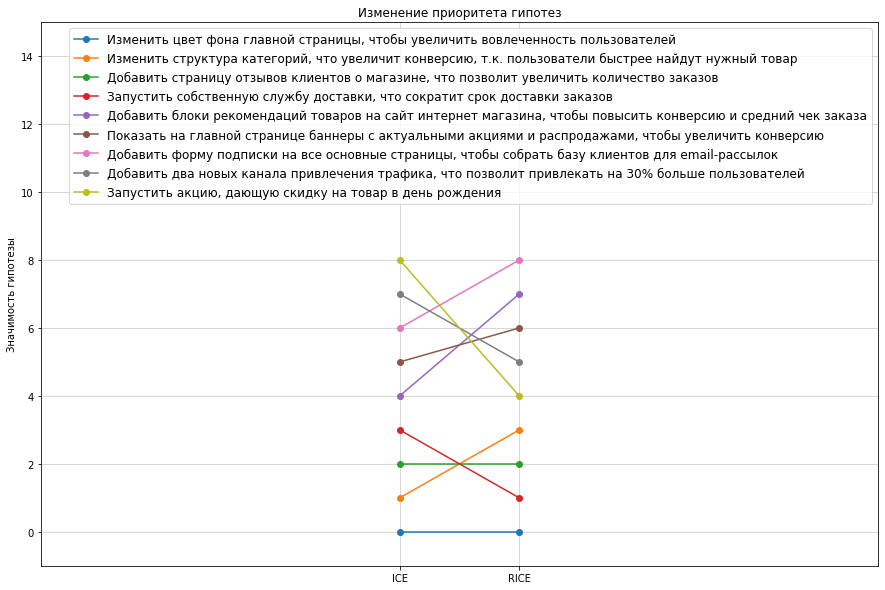

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))

for i in hyp.index:
    ax.plot(t_all.iloc[i, [0, 2]], marker ='o', label=f'{t_all.iloc[i, 1]}')
plt.ylabel('Значимость гипотезы')
plt.ylim(-1, 15)
plt.xlim(-3, 4)
plt.grid(linestyle='-', linewidth=0.5)
plt.legend(loc='upper right', fontsize='large')
plt.title('Изменение приоритета гипотез')
plt.show()

### Выводы
При обоих методах в лидерах гипотезы 7 и 0 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", при том, что форму подписки на основных страницах увидят почти все посетители сайта, а новые каналы трафика, вероятно, 30% пользователей.

Гипотеза "Запустить акцию, дающую скидку на товар в день рождения", несмотря на то, что затрагивает вроде бы всех пользователей, затрагивает их не одномоментно, к тому же информацию о новой ации нужно еще до них донести. Поэтому при применении метода RICE вместо ICE эта гипотеза опускается с 1 на 5 место. 

Так как мы предполагаем, что блоки рекомендаций увидит очень большая доля пользователей, гипотеза 2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" поднимается с пятого места до второго. 


## Анализ A/B-теста - кумулятивные метрики

Мы провели A/B-тест и получили результаты, которые описаны в файлах `ab-orders.csv` и `ab-visitors.csv`.

Проанализируем A/B-тест.

Первым делом проверим, нет ли пользователей, попавших одновременно в обе группы.

In [10]:
doubles = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'transaction_id' : 'count', 'revenue' : 'sum'}).reset_index()
print(f'Пользователей, попавших в обе группы: {doubles[doubles.group != 1]["visitor_id"].count()}')
print(f"Сумма заказов этих пользователей {doubles[doubles.group != 1]['revenue'].sum()}")
print(f"Количество их заказов {doubles[doubles.group != 1]['transaction_id'].sum()}")

Пользователей, попавших в обе группы: 58
Сумма заказов этих пользователей 1558935
Количество их заказов 181


Оказывается, 58 пользователей попали в обе группы. Всего эти пользователи совершили 181 заказ на более чем 1,5 млн рублей. Неизвестно, какая из версий исследуемой страницы повлияла на их решения, значит, результаты исследования нельзя интерпретировать однозначно. Следует исключить этих пользователей из исследования.

In [11]:
d_list = list(doubles[doubles.group != 1]['visitor_id'])
orders_good = orders.query('visitor_id not in @d_list')

### Кумулятивная выручка

In [12]:
# кумулятивные по дням данные о заказах
orders_agg_a = orders_good[orders_good['group'] == 'A'].groupby('date').agg({'transaction_id' : 'nunique', 
                                       'visitor_id' : 'nunique', 
                                       'revenue' : 'sum'}).sort_values(by='date').cumsum().reset_index()


orders_agg_b = orders_good[orders_good['group'] == 'B'].groupby('date').agg({'transaction_id' : 'nunique', 
                                       'visitor_id' : 'nunique', 
                                       'revenue' : 'sum'}).sort_values(by='date').cumsum().reset_index()

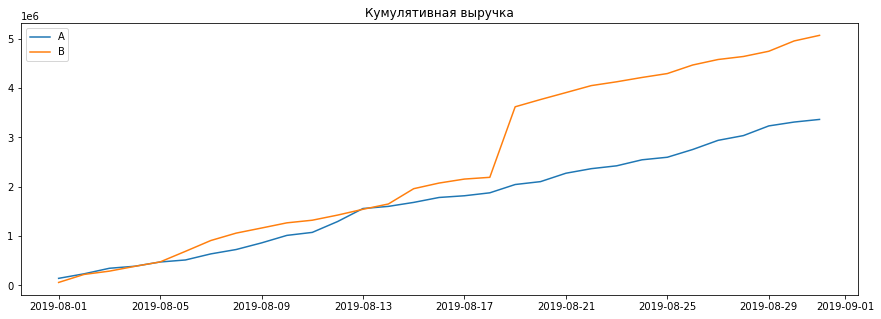

In [13]:
# построим графики
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_agg_a.date, orders_agg_a.revenue, label = 'A')
ax.plot(orders_agg_b.date, orders_agg_b.revenue, label = 'B')
plt.legend()
plt.title('Кумулятивная выручка')
plt.show()

Выручка в обеих группах увеличивается на протяжении всего теста. Однако в группе B есть резкий всплеск, который может свидетельствовать о всплеске числа заказов или о появлении неожидано дорогих заказов.

### Кумулятивный средний чек

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

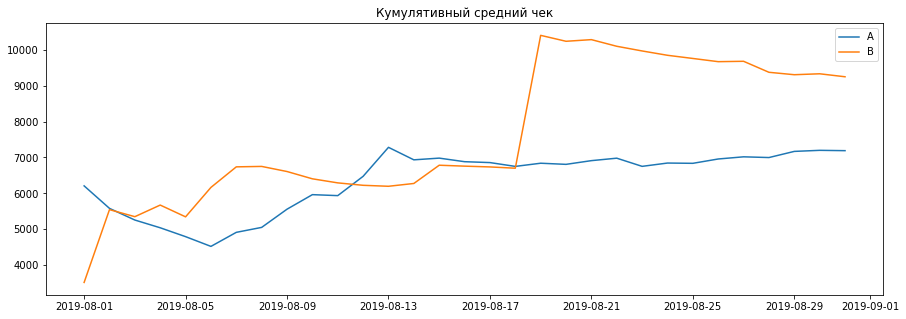

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_agg_a.date, orders_agg_a.revenue / orders_agg_a.transaction_id, label = 'A')
ax.plot(orders_agg_b.date, orders_agg_b.revenue / orders_agg_b.transaction_id, label = 'B')
plt.legend()
plt.title('Кумулятивный средний чек')
plt.show()

Средний чек в группе A за первые две недели подрос и стабилизировался, а в группе B резко подскочил и стал плавно снижаться к концу теста. Вероятно, в группу B попали какие-то крупные заказы, судя по резкому всплеску на графике. 

### Отношение средних чеков

In [15]:
# собираем общую таблицу
orders_agg = orders_agg_a.merge(orders_agg_b, on='date', how='left', suffixes=('_A', '_B'))
orders_agg['rel_rev'] = (
    (orders_agg.revenue_B  / orders_agg.transaction_id_B ) 
    / (orders_agg.revenue_A  / orders_agg.transaction_id_A ) - 1
)

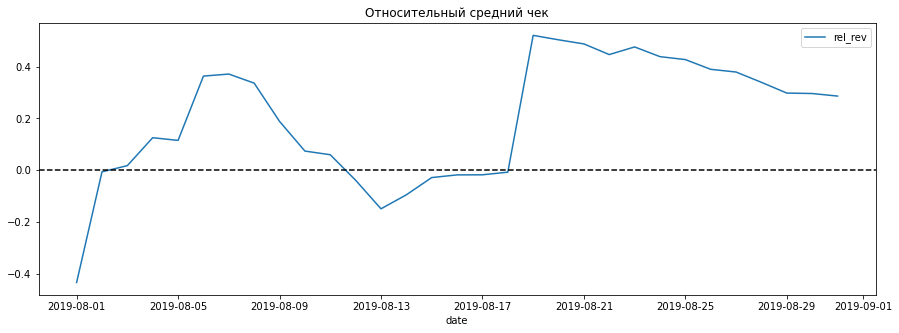

In [16]:
# строим график
orders_agg.plot('date', 'rel_rev', figsize=(15, 5))
plt.title('Относительный средний чек')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Скачок около 20 августа продолжает сохраняться. В этот момент наверняка случился какой-то экстремально крупный заказ.

### Кумулятивная конверсия

In [17]:
#добавляем данные о посетителях
orders_agg_a['vis_agg_a'] = visitors[visitors['group'] == 'A']['visitors'].reset_index(drop=True).cumsum(axis=0)
orders_agg_b['vis_agg_b'] = visitors[visitors['group'] == 'B']['visitors'].reset_index(drop=True).cumsum(axis=0)


In [18]:
# считаем конверсию
orders_agg_a['conversion_A'] = orders_agg_a.transaction_id / orders_agg_a.vis_agg_a
orders_agg_b['conversion_B'] = orders_agg_b.transaction_id / orders_agg_b.vis_agg_b

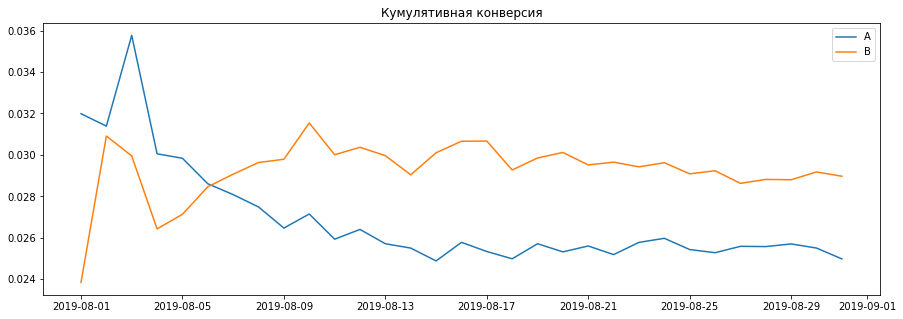

In [19]:
# строим график
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_agg_a.date, orders_agg_a['conversion_A'], label = 'A')
ax.plot(orders_agg_b.date, orders_agg_b['conversion_B'], label = 'B')
plt.legend()
plt.title('Кумулятивная конверсия')
plt.show()

Группы стартовали с очень разных значений, но затем группа A постепенно просела, а группа B стабилизировалась - причем стабильно выше группы A. 

### Относительная конверсия 

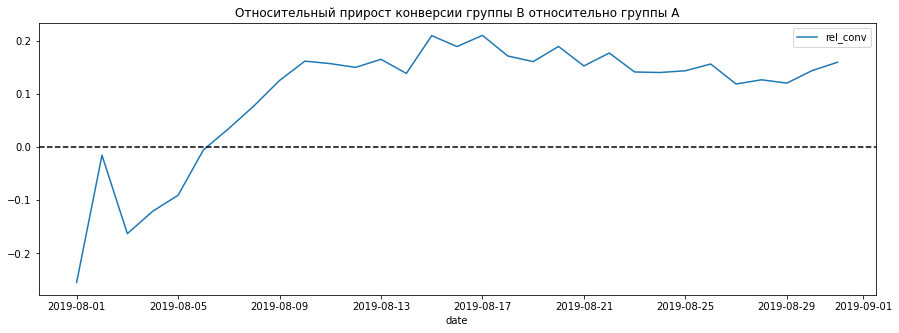

In [20]:
orders_agg['rel_conv'] = orders_agg_b['conversion_B'] / orders_agg_a['conversion_A'] - 1
# строим график
orders_agg.plot('date', 'rel_conv', figsize=(15, 5))
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

В целом отношение конверсий стабилизировалось - причем группа A проигрывает группе B на протяжении почти всего теста. 

### Вывод 

- Анализ графиков кумулятивных метрик (среднего чека, конверсии) позволяет предположить, что среди заказов в группе B есть экстремально большие, которые сильно влияют на прирост среднего чека. 

- Конверсия в группах к концу теста стабилизировалась, причем в группе A она выше. 

## Анализ выбросов

### Распределение заказов по пользователям

Подсчитаем количество заказов по пользователям.

In [21]:
orders_by_user = orders_good.groupby('visitor_id')['transaction_id'].nunique()
orders_by_user.sort_values(ascending=False).head(10)

visitor_id
249864742     3
3908431265    3
2742574263    3
3967698036    3
611059232     3
2988190573    3
2108163459    3
3941503500    2
406208401     2
4134830387    2
Name: transaction_id, dtype: int64

Построим точечную диаграмму числа заказов на одного пользователя

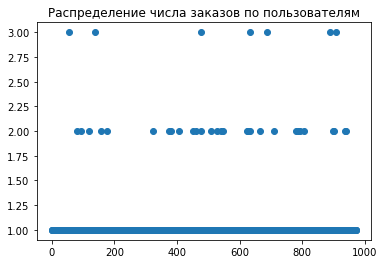

In [22]:
plt.scatter(pd.Series(range(0,len(orders_by_user))), orders_by_user)
plt.title('Распределение числа заказов по пользователям')
plt.show()

Большинство пользователей сделали 1 заказ, некоторые - 2, и всего 7 человек - 3 заказа. 

Посчитаем выборочные перцентили количества заказов на одного пользователя

In [23]:
# доля пользователей с более чем 1 заказом
print('{:.2%}'.format(len(orders_by_user[orders_by_user > 1]) / len(orders_by_user)))

3.70%


Менее 4% пользователей оформили больше 1 заказа. Следует отсеять как аномальных пользователей с 2 и 3 заказами. 

### Распределение стоимостей заказов

Посмотрим на информацию о стоимостях заказов

In [24]:
orders_good['revenue'].describe(percentiles=[0.05, 0.50, 0.90, 0.95, 0.99])

count   1016.00   
mean    8300.81   
std     42121.99  
min     50.00     
5%      300.00    
50%     2955.00   
90%     17990.00  
95%     26785.00  
99%     53904.00  
max     1294500.00
Name: revenue, dtype: float64

95-й и 99-й перцентили стоимости заказов - 26785 и 53904 рубля соответственно.

Построим точечную диаграмму распределения стоимостей заказов

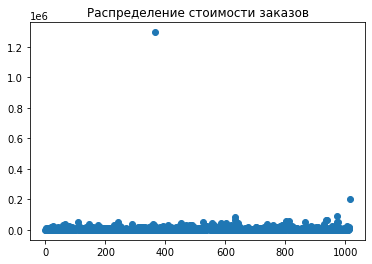

In [25]:
plt.scatter(pd.Series(range(0,len(orders_good))), orders_good['revenue'])
plt.title('Распределение стоимости заказов')
plt.show()

In [26]:
# доля заказов дороже, чем 27000
print('{:.2%}'.format(len(orders_good[orders_good.revenue > 27000]) / len(orders_good)))

5.02%


Примерно чем 5% заказов дороже, чем 26785 рублей, и есть один выброс - заказ стоимостью почти 1,3 миллиона! Скорее всего, именно он причина скачка на графиках. Кроме того, как аномальные можно отсеять заказы стоимостью выше 27000 рублей. 

##  Статистический анализ

### Анализ на сырых данных
Подготовим "сырые" данные.

In [27]:
# таблица со сгруппированными по дня и группам заказами
orders_date = orders_good.groupby(['date', 'group']).agg({'transaction_id' : 'nunique', 
                                       'visitor_id' : 'nunique', 
                                       'revenue' : 'sum'}).sort_values(by=['date','group']).reset_index()
orders_date.head(5)

date group  transaction_id  visitor_id  revenue
0  2019-08-01  A     23              19          142779 
1  2019-08-01  B     17              17          59758  
2  2019-08-02  A     19              18          91602  
3  2019-08-02  B     23              22          162043 
4  2019-08-03  A     24              24          112473

In [28]:
# по группе A

data_a = orders_agg_a[['date', 'transaction_id', 'revenue', 'vis_agg_a']].merge(orders_date[orders_date['group']=='A']
                                                                                [['date', 'transaction_id', 'revenue']], 
                  on='date', how='left')

data_a = data_a.merge(visitors[visitors['group'] == 'A'][['date', 'visitors']], on='date', how='left')

data_a.set_axis(['date', 'orders_agg', 'revenue_agg', 'visiters_agg', 'orders_daily', 'revenue_daily', 'visitors_daily'], 
                axis='columns', inplace=True)

In [29]:
# по группе B
data_b = orders_agg_b[['date', 'transaction_id', 'revenue', 'vis_agg_b']].merge(orders_date[orders_date['group']=='B']
                                                                                [['date', 'transaction_id', 'revenue']], 
                  on='date', how='left')


data_b = data_b.merge(visitors[visitors['group'] == 'B'][['date', 'visitors']], on='date', how='left')

data_b.set_axis(['date', 'orders_agg', 'revenue_agg', 'visiters_agg', 'orders_daily', 'revenue_daily', 'visitors_daily'], 
                axis='columns', inplace=True)

In [30]:
# создание списков для анализа конверсии
order_users_A = (
    orders_good[orders_good['group'] == 'A'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

order_users_B = (
    orders_good[orders_good['group'] == 'B'].groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

sample_A = pd.concat([order_users_A['transaction_id'], 
                     pd.Series(0,index=np.arange(data_a['visitors_daily'].sum() - len(order_users_A['transaction_id'])), 
                               name='orders')], axis=0)

sample_B = pd.concat([order_users_B['transaction_id'], 
                     pd.Series(0,index=np.arange(data_b['visitors_daily'].sum() - len(order_users_B['transaction_id'])), 
                               name='orders')], axis=0)

Нулевая гипотеза H0 - статистически значимых различий в конверсии между группами нет.

Гипотеза H1 - статистически значимые различия есть. 

In [31]:
print("{0:.3f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))

print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

0.006
0.160


По "сырым" данным различия между группами A и B есть: `p-value` меньше 0.05, и нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, следует отвергнуть. 

Относительный выигрыш группы B равен 16%.

In [32]:
print("{0:.3f}".format(st.mannwhitneyu(sample_A, sample_B, alternative="two-sided")[1]))

0.011


С применением двусторонней проверки `p-value` в два раза больше, но все еще меньше 0.05 

Найдём относительные различия в среднем чеке между группами:

Нулевая гипотеза H0 - статистически значимых различий в среднем чеке между группами нет.

Гипотеза H1 - статистически значимые различия есть. 

In [33]:
print('{0:.3f}'.format(st.mannwhitneyu(orders_good[orders_good['group']=='A']['revenue'], 
                                       orders_good[orders_good['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders_good[orders_good['group']=='B']['revenue'].mean()/
                       orders_good[orders_good['group']=='A']['revenue'].mean()-1))

0.415
0.287


По сырым данным различий между средними чеками нет: `P-value` значительно больше 0.05, значит, причин отвергать нулевую гипотезу, нет. 

Средний чек группы B значительно выше среднего чека группы A.

In [34]:
print('{0:.3f}'.format(st.mannwhitneyu(orders_good[orders_good['group']=='A']['revenue'], 
                                       orders_good[orders_good['group']=='B']['revenue'], alternative="two-sided")[1]))

0.829


С применением двусторонней проверки `p-value` в два раза больше. 

### Анализ на данных без выбросов

Ранее мы приняли за аномальных пользователей тех, кто совершил более 1 заказа или совершил заказ дороже 27000 рублей.

Узнаем, сколько всего аномальных пользователей.

In [35]:
# пользователи с несколькими заказами

mult_orders = orders_good.groupby('visitor_id')['transaction_id'].count().reset_index()
mult_orders = mult_orders[mult_orders['transaction_id'] > 1]['visitor_id']

# пользователи с дорогими заказами

expensive_orders = orders_good[orders_good['revenue'] > 27000]['visitor_id'].reset_index(drop=True)

abnormal_users = pd.Series((list(mult_orders) + list(expensive_orders)), name='visitors_id').drop_duplicates()
print(abnormal_users.head())
len(abnormal_users)

0    249864742
1    366673373
2    406208401
3    522292794
4    611059232
Name: visitors_id, dtype: int64


86

Всего таких пользователей 86. 

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [36]:
sample_A_filt = pd.concat([order_users_A.query('not visitor_id in @abnormal_users')['transaction_id'], 
                          pd.Series(0, index=np.arange(data_a['visitors_daily'].sum() - len(order_users_A['transaction_id'])), 
                                    name='orders')], axis=0)
sample_B_filt = pd.concat([order_users_B.query('not visitor_id in @abnormal_users')['transaction_id'], 
                          pd.Series(0, index=np.arange(data_b['visitors_daily'].sum() - len(order_users_B['transaction_id'])), 
                                    name='orders')], axis=0)

In [37]:
print('{0:.3f}'.format(st.mannwhitneyu(sample_A_filt, sample_B_filt)[1]))
print('{0:.3f}'.format(sample_B_filt.mean()/sample_A_filt.mean()-1))

0.008
0.174


По "очищенным" данным различия между группами A и B также есть: `p-value` заметно меньше 0.05, и нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, следует отвергнуть. 

Относительный выигрыш группы B увеличился и равен 17,4%.

Проверим, как изменились результаты по среднему чеку.

In [38]:
print('{0:.3f}'.format(st.mannwhitneyu(orders_good.query('group == "A" and not visitor_id in @abnormal_users')['revenue'], 
                                      orders_good.query('group == "B" and not visitor_id in @abnormal_users')['revenue'])[1]))

print('{0:.3f}'.format(orders_good.query('group == "B" and not visitor_id in @abnormal_users')['revenue'].mean() / 
                       orders_good.query('group == "A" and not visitor_id in @abnormal_users')['revenue'].mean() - 1))

0.364
-0.034


`P-value` уменьшился, но остался значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, по-прежнему нет. А вот средний чек группы B без выбросов стал ниже среднего чека группы A, хотя и ненамного.

In [39]:
# отфильтруем из списка заказов заказы "аномальных" пользователей
orders_super_good = orders_good.query('not visitor_id in @abnormal_users')
# составим сводную кумулятивную таблицу
o_pivot = orders_super_good.pivot_table(index='date', columns='group', 
                                        aggfunc={'transaction_id': 'nunique','revenue': 'sum'}).sort_index()
o_pivot = o_pivot.cumsum().reset_index()
o_pivot['rel_rev'] = (
    (o_pivot[('revenue', 'B')]  / o_pivot[('transaction_id', 'B')] ) 
    / (o_pivot[('revenue', 'A')]  / o_pivot[('transaction_id', 'A')] ) - 1
)

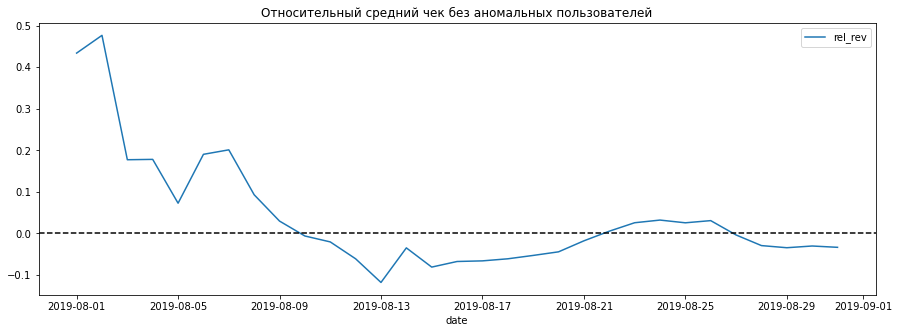

In [40]:
# построим график
o_pivot.plot('date', 'rel_rev', figsize=(15, 5))
plt.title('Относительный средний чек без аномальных пользователей')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

## Выводы

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Как по сырым, так и по данным без аномалий нет статистически значимого различия по среднему чеку между группами. 
- График различия конверсии между группами показывает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
- График различия среднего чека до фильтрации аномалий колеблется: именно благодаря ему мы нашли аномалии. Сделать из этого графика определённые выводы нельзя.
- График различия среднего чека после фильтрации постепенно стабилизировался около 0 - значимых различий между средними чеками в разных группах нет. 
- В целом тест можно остановить. Мы учидели прирост конверсии в группе B, но на среднем чеке проверяемая гипотеза не сказалась. 